In [115]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')
import denn.utils
from collections import OrderedDict

COLORS = ["crimson", "blue", "aquamarine"]

def load_traces(dirname, skipstep=1):
    soln = np.load(os.path.join(dirname, "soln_pred.npy"))
    grid = np.load(os.path.join(dirname, "grid.npy"))
    pred = np.load(os.path.join(dirname, "pred_pred.npy"))

    print(f"Grid {grid.shape} Soln {soln.shape} Pred {pred.shape}")

    # skipping for gif size
    soln = soln[:,::skipstep]
    grid = grid[:,::skipstep]
    pred = pred[:,::skipstep]

    return dict(soln=soln, grid=grid, pred=pred)

def load_multiline_traces(dirname, numlines, skipstep=1):
    soln = np.load(os.path.join(dirname, "soln_pred.npy"))
    grid = np.load(os.path.join(dirname, "grid.npy"))
    pred = np.load(os.path.join(dirname, "pred_pred.npy"))

    print(f"Grid {grid.shape} Soln {soln.shape} Pred {pred.shape}")
    
    res = dict(grid=grid)
    
    for i in range(numlines):
        _pred = pred[:, i::numlines]
        _soln = soln[:, i::numlines]
        res[f"pred{i}"] = _pred[:, ::skipstep] # skip for gif size, if desired
        res[f"soln{i}"] = _soln[:, ::skipstep]

    return res

def load_surface_traces(dirname, skipstep=1):
    soln = np.load(os.path.join(dirname, "soln_pred.npy"))
    grid = np.load(os.path.join(dirname, "grid.npy"))
    pred = np.load(os.path.join(dirname, "pred_pred.npy"))

    print(f"Grid {grid.shape} Soln {soln.shape} Pred {pred.shape}")
    
    pred = pred[:, ::skipstep]
    
    return dict(grid=grid, pred=pred)

def make_line_ax(v, ax):
    line1, = ax.plot([],[], lw=3, linestyle="solid", color='crimson', alpha=0.7, label="pred")
    line2, = ax.plot([],[], lw=3, linestyle="dashed", color='blue', alpha=0.7, label="true")
    ax.set_xlim(v['grid'].min(), v['grid'].max())
    ax.set_ylim(v['soln'].min(), v['soln'].max())
    return OrderedDict(dict(pred=line1, soln=line2))

def fill_line_data(lines, i, t, v):
    x = v['grid'].flatten()
    j = min(i, v['pred'].shape[1] - 1)
    pred = v['pred'][:, j]
    soln = v['soln'][:, j]
    lines[t]['pred'].set_data(x, pred)
    lines[t]['soln'].set_data(x, soln)
    
def make_multiline_ax(v, ax):
    numlines = (len(v.keys()) - 1)//2
    res = {}
    
    for i in range(numlines):
        pred, = ax.plot([],[], lw=3, linestyle="solid", color=COLORS[i], alpha=0.7, label="pred")
        soln, = ax.plot([],[], lw=3, linestyle="dashed", color=COLORS[i], alpha=0.7, label="true")
        res[f"pred{i}"] = pred
        res[f"soln{i}"] = soln

    ax.set_xlim(v['grid'].min(), v['grid'].max())
    
    ymin = min([v[f'soln{i}'].min() for i in range(numlines)])
    ymax = max([v[f'soln{i}'].max() for i in range(numlines)])
    
    ax.set_ylim(ymin, ymax)
    
    return OrderedDict(res)

def fill_multiline_data(lines, i, t, v):
    x = v['grid'].flatten()
    for k in lines[t].keys():
        j = min(i, v[k].shape[1] - 1)
        lines[t][k].set_data(x, v[k][:, j])
    
def make_surface_ax(v, ax):
    x, y, = v['grid'][:,0], v['grid'][:, 1]
    xdim, ydim = int(np.sqrt(len(x))), int(np.sqrt(len(y)))
    surf = ax.contourf(np.zeros((xdim, ydim)), cmap='Reds')
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    return OrderedDict(dict(pred=surf))

def fill_surface_data(ax, i, t, v):
    x, y = v['grid'][:,0], v['grid'][:,1]
    j = min(i, v['pred'].shape[1] - 1)
    z = v['pred'][:, j]
    
    xdim, ydim = int(np.sqrt(len(x))), int(np.sqrt(len(y)))
    xx, yy = x.reshape((xdim, ydim)), y.reshape((xdim, ydim))
    z = z.reshape((xdim, ydim))
    
    ax.contourf(xx, yy, z, cmap="Reds")

def make_animation(name, traces):
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    ax = ax.ravel()

    lines = {}
    for i, (t, v) in enumerate(traces.items()):
        if t == "POS":
            lines[t] = make_surface_ax(v, ax[i])
        elif t in ["NAS", "SIR"]:
            lines[t] = make_multiline_ax(v, ax[i])
        else:
            lines[t] = make_line_ax(v, ax[i])
        ax[i].set_title(t)
        
    fig.tight_layout()

    def animate(i):
        for tidx, (t, v) in enumerate(traces.items()):
            if t == "POS":
                fill_surface_data(ax[tidx], i, t, v)
            elif t in ["NAS", "SIR"]:
                fill_multiline_data(lines, i, t, v)
            else:
                fill_line_data(lines, i, t, v)

        artists = [ll for l in lines.values() for ll in l.values()]
        return artists

    anim = FuncAnimation(fig, animate, frames=100, interval=1, blit=False)


    anim.save(f'{name}.gif')

Grid (100, 1) Soln (100, 2000) Pred (100, 2000)
Grid (400, 1) Soln (400, 10000) Pred (400, 10000)
Grid (400, 1) Soln (400, 20000) Pred (400, 20000)
Grid (800, 1) Soln (800, 100000) Pred (800, 100000)
Grid (800, 1) Soln (800, 90000) Pred (800, 90000)
Grid (1024, 2) Soln (1024, 4000) Pred (1024, 4000)


MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


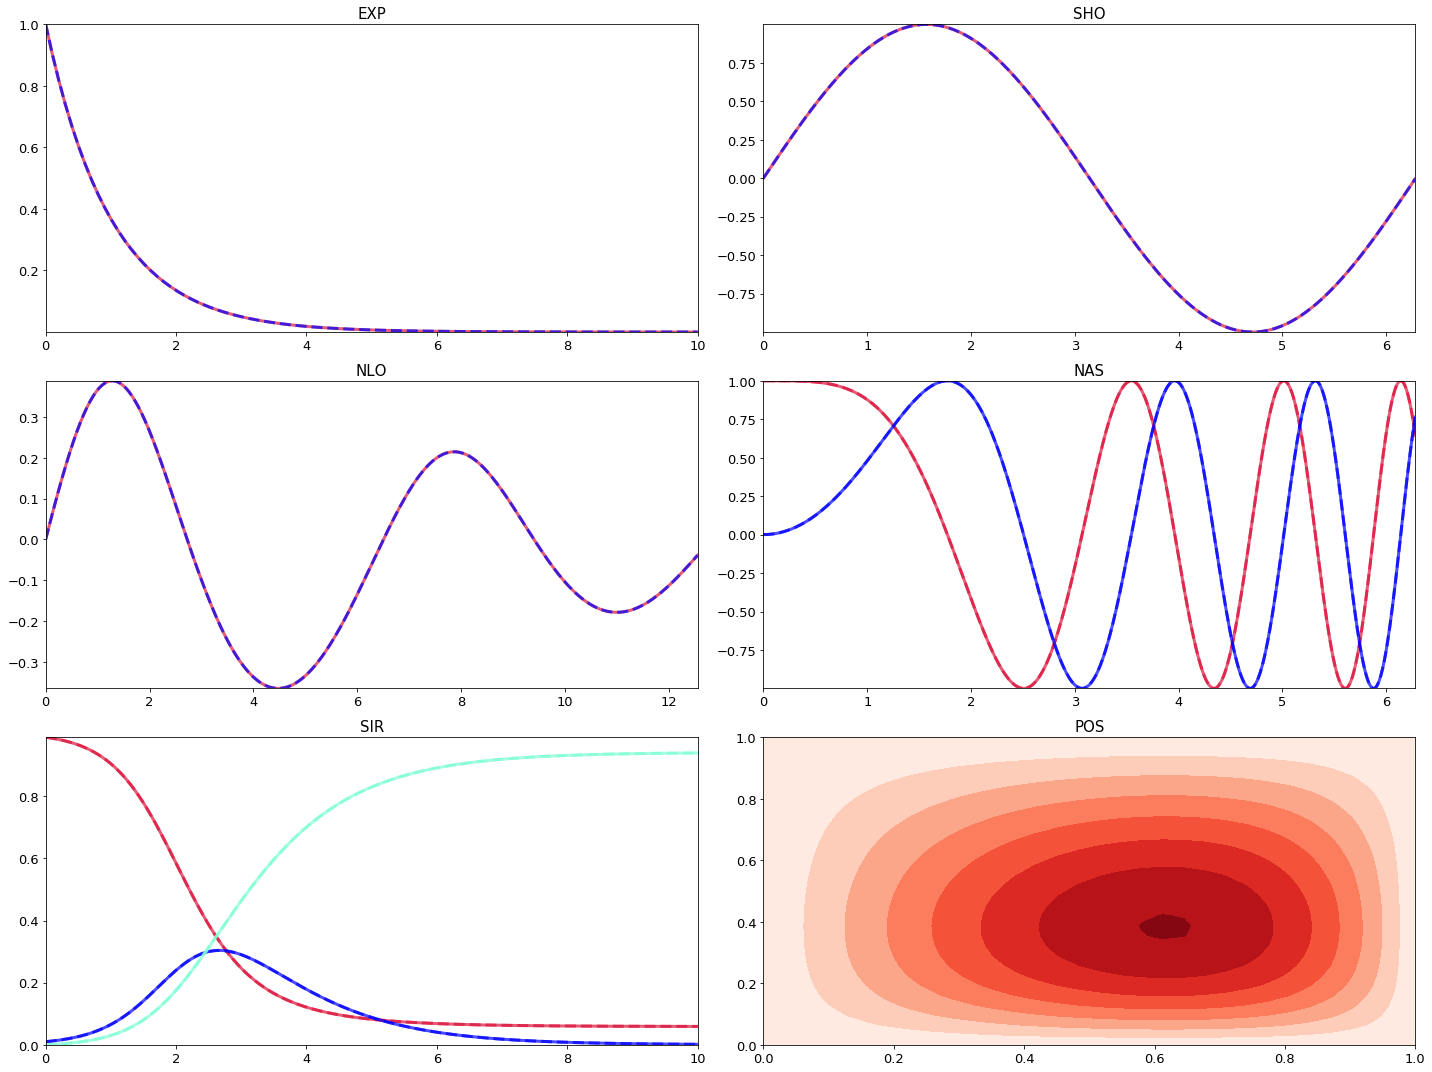

In [116]:
exp = "/Users/dylanrandle/Downloads/EXP_run_061220_anim/animation/"
sho = "/Users/dylanrandle/Downloads/SHO_run_061220_anim/animation/"
nlo = "/Users/dylanrandle/Downloads/NLO_run_061220_anim/animation/"
coo = "/Users/dylanrandle/Downloads/COO_run_061220_anim/animation/"
sir = "/Users/dylanrandle/Downloads/SIR_run_061220_anim/animation/"
pos = "/Users/dylanrandle/Downloads/POS_run_061220_anim/animation/"

exptr = load_traces(exp, skipstep=20)
shotr = load_traces(sho, skipstep=100)
nlotr = load_traces(nlo, skipstep=200)
cootr = load_multiline_traces(coo, 2, skipstep=500)
sirtr = load_multiline_traces(sir, 3, skipstep=300)
postr = load_surface_traces(pos, skipstep=40)

traces = OrderedDict({
    "EXP": exptr,
    "SHO": shotr,
    "NLO": nlotr,
    "NAS": cootr,
    "SIR": sirtr,
    "POS": postr
})

make_animation('deqgan', traces)